<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Autoregression-modelling-of-Time-series-for-Outlier-detection" data-toc-modified-id="Autoregression-modelling-of-Time-series-for-Outlier-detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Autoregression modelling of Time series for Outlier detection</a></span></li><li><span><a href="#Persistence-Model" data-toc-modified-id="Persistence-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Persistence Model</a></span></li><li><span><a href="#AutoRegression-model" data-toc-modified-id="AutoRegression-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>AutoRegression model</a></span><ul class="toc-item"><li><span><a href="#Auto-Correlation-at-lag-=-k" data-toc-modified-id="Auto-Correlation-at-lag-=-k-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Auto Correlation at lag = k</a></span></li></ul></li><li><span><a href="#Get-all-anomalies" data-toc-modified-id="Get-all-anomalies-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get all anomalies</a></span></li><li><span><a href="#Using-AR-to-model-whole-TS" data-toc-modified-id="Using-AR-to-model-whole-TS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Using AR to model whole TS</a></span></li><li><span><a href="#Determine-Seasonality" data-toc-modified-id="Determine-Seasonality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Determine Seasonality</a></span></li><li><span><a href="#Stationarize-Time-Series-acc-to-Seasonality" data-toc-modified-id="Stationarize-Time-Series-acc-to-Seasonality-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Stationarize Time Series acc to Seasonality</a></span></li><li><span><a href="#Retrain-AutoReg-on-Stationary-TS" data-toc-modified-id="Retrain-AutoReg-on-Stationary-TS-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Retrain AutoReg on Stationary TS</a></span></li><li><span><a href="#Test-Stationarity-using-the-Augmented-Dicky-Fuller-Test" data-toc-modified-id="Test-Stationarity-using-the-Augmented-Dicky-Fuller-Test-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Test Stationarity using the Augmented Dicky Fuller Test</a></span></li><li><span><a href="#Define-threshold" data-toc-modified-id="Define-threshold-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Define threshold</a></span></li><li><span><a href="#See-if-AR-model-+-threshold-=-Anomalies" data-toc-modified-id="See-if-AR-model-+-threshold-=-Anomalies-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>See if AR model + threshold = Anomalies</a></span></li><li><span><a href="#Anomaly-Detection-with-the-differenced-AR-model" data-toc-modified-id="Anomaly-Detection-with-the-differenced-AR-model-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Anomaly Detection with the differenced AR model</a></span></li><li><span><a href="#Calculate-F1-score" data-toc-modified-id="Calculate-F1-score-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Calculate F1 score</a></span></li><li><span><a href="#Doing-this-in-a-loop" data-toc-modified-id="Doing-this-in-a-loop-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Doing this in a loop</a></span></li></ul></div>

# Autoregression modelling of Time series for Outlier detection 
By Sanket Mehrotra

Source Ref: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

A regression model provides an output based on a linear combination of input values
$$
\hat{y} = b_0 + b_1*X_1
$$

an AR model assumes autocorrelation

The stronger the correlation between the output variable and a specific lagged variable, the **more weight** that autoregression model can put on that variable when modeling.

In [1]:
import os
os.getcwd()

'D:\\Temp\\time-series\\code'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt 
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
series = pd.read_csv('D://Temp/time-series/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv')

print(series.head())

    timestamp       value  is_anomaly
0  1416726000   13.894031           0
1  1416729600   33.578274           0
2  1416733200   88.933746           0
3  1416736800  125.389424           0
4  1416740400  152.962000           0


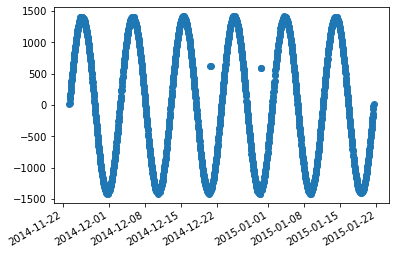

In [4]:
series['timestamp'] = pd.to_datetime(series['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
plt.plot_date(series['timestamp'],series['value'])
plt.gcf().autofmt_xdate()

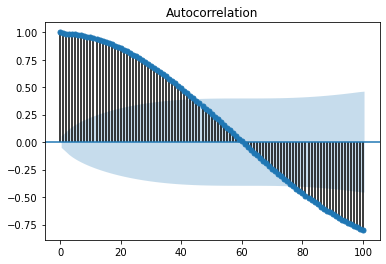

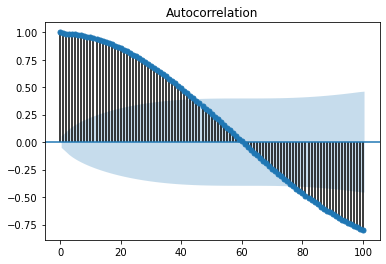

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
#series = pd.read_csv('D://Temp/time-series/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv')
plot_acf(series['value'], lags=100)
#plt.clf()

In [6]:
df_indexed = series.copy().set_index('timestamp')

In [7]:
# create lagged dataset
values = pd.DataFrame(series.value)
lagged_df = pd.concat([values.shift(1),values],axis =1)
print("df\n",lagged_df.head())
lagged_df.columns = ['t-1','t']
result = lagged_df.corr()
print("Correlation Matrix Result for lag = 1: ", "\n" ,result)


df
         value       value
0         NaN   13.894031
1   13.894031   33.578274
2   33.578274   88.933746
3   88.933746  125.389424
4  125.389424  152.962000
Correlation Matrix Result for lag = 1:  
           t-1         t
t-1  1.000000  0.993903
t    0.993903  1.000000


In [8]:
# split into train and test sets
X = lagged_df.values
print("X","\n",X)
train, test = X[1:len(X)-7], X[len(X)-7:]
print("\ntrain\n",train,"\ntest\n",test)
train_X, train_y = train[:,0], train[:,1]
print("\ntrainX\n",train_X,"\ntrain_y\n",train_y)
test_X, test_y = test[:,0], test[:,1]
print("\ntestX\n",test_X,"\ntest_y\n",test_y)

X 
 [[          nan   13.8940312 ]
 [  13.8940312    33.57827355]
 [  33.57827355   88.93374618]
 ...
 [-139.65783427  -70.55065181]
 [ -70.55065181  -16.85714756]
 [ -16.85714756    7.75765952]]

train
 [[  13.8940312    33.57827355]
 [  33.57827355   88.93374618]
 [  88.93374618  125.3894237 ]
 ...
 [-378.74044506 -340.50852173]
 [-340.50852173 -292.65126129]
 [-292.65126129 -251.27630666]] 
test
 [[-251.27630666 -201.52864723]
 [-201.52864723 -187.47196836]
 [-187.47196836 -141.4197665 ]
 [-141.4197665  -139.65783427]
 [-139.65783427  -70.55065181]
 [ -70.55065181  -16.85714756]
 [ -16.85714756    7.75765952]]

trainX
 [  13.8940312    33.57827355   88.93374618 ... -378.74044506 -340.50852173
 -292.65126129] 
train_y
 [  33.57827355   88.93374618  125.3894237  ... -340.50852173 -292.65126129
 -251.27630666]

testX
 [-251.27630666 -201.52864723 -187.47196836 -141.4197665  -139.65783427
  -70.55065181  -16.85714756] 
test_y
 [-201.52864723 -187.47196836 -141.4197665  -139.65783427  -7

# Persistence Model

Test MSE: 1865.859


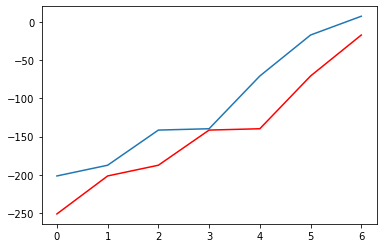

In [9]:
#Persistence Model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
fig1 = plt.figure()
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

# AutoRegression model

In [10]:
from statsmodels.tsa.ar_model import AutoReg

#Load the series
#series = pd.read_csv('D://Temp/time-series/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv')
series = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M2.csv')

In [11]:
# split dataset
X = series.value
train, test = X[1:len(X)-20], X[len(X)-20:]

In [12]:
# train autoregression
model = AutoReg(train, lags=31)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept    3.294900
value.L1     1.008510
value.L2    -0.304777
value.L3     0.309467
value.L4    -0.083403
value.L5     0.082144
value.L6    -0.013783
value.L7     0.022325
value.L8    -0.003608
value.L9    -0.001827
value.L10    0.014466
value.L11   -0.008859
value.L12    0.002838
value.L13   -0.003872
value.L14    0.002262
value.L15   -0.004177
value.L16    0.005071
value.L17   -0.002992
value.L18    0.000431
value.L19    0.005712
value.L20   -0.008017
value.L21    0.003559
value.L22    0.002808
value.L23   -0.005515
value.L24   -0.002591
value.L25    0.005358
value.L26   -0.003214
value.L27   -0.003940
value.L28    0.001268
value.L29   -0.009003
value.L30   -0.004923
value.L31   -0.020971
dtype: float64


In [13]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions = predictions.replace(np.nan,0)
for i in range(len(predictions)):
 	print('predicted=%f, expected=%f' % (predictions.iloc[i], test.iloc[i]))


predicted=1225.164109, expected=1235.675464
predicted=1207.872002, expected=1214.292346
predicted=1188.810310, expected=1203.992032
predicted=1169.979917, expected=1193.921030
predicted=1150.827075, expected=1175.248490
predicted=1131.802930, expected=1140.133179
predicted=1111.390399, expected=1107.399957
predicted=1091.264759, expected=1105.250352
predicted=1070.622250, expected=1080.973567
predicted=1049.575855, expected=1038.521562
predicted=1027.749959, expected=1008.264778
predicted=1006.404843, expected=992.600101
predicted=984.454484, expected=971.327344
predicted=961.970539, expected=937.683459
predicted=939.543946, expected=900.815630
predicted=916.949845, expected=874.421670
predicted=894.753660, expected=863.603996
predicted=871.044997, expected=832.340474
predicted=847.501075, expected=798.155829
predicted=0.000000, expected=756.312359


In [14]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 170.824


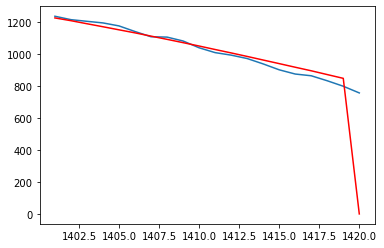

In [15]:
#plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Auto Correlation at lag = k 

Calculate the Pearson Correlation coefficient for different lags to see how that varies.

In [16]:
values = pd.DataFrame(series.value)
values

,value
0,13.894031
1,33.578274
2,88.933746
3,125.389424
4,152.962000
...,...
1416,874.421670
1417,863.603996
1418,832.340474
1419,798.155829


In [17]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions = predictions.replace(np.nan,0)

Lag : 0

Test RMSE: 170.82369157849405
     t-0    t
t-0  1.0  1.0
t    1.0  1.0



Lag : 1

Test RMSE: 170.82369157849405
          t-1         t
t-1  1.000000  0.990448
t    0.990448  1.000000



Lag : 2

Test RMSE: 170.82369157849405
          t-2         t
t-2  1.000000  0.980396
t    0.980396  1.000000



Lag : 3

Test RMSE: 170.82369157849405
          t-3         t
t-3  1.000000  0.975087
t    0.975087  1.000000



Lag : 4

Test RMSE: 170.82369157849405
          t-4         t
t-4  1.000000  0.969238
t    0.969238  1.000000



Lag : 5

Test RMSE: 170.82369157849405
          t-5         t
t-5  1.000000  0.962735
t    0.962735  1.000000



Lag : 6

Test RMSE: 170.82369157849405
         t-6        t
t-6  1.00000  0.95581
t    0.95581  1.00000



Lag : 7

Test RMSE: 170.82369157849405
          t-7         t
t-7  1.000000  0.948306
t    0.948306  1.000000



Lag : 8

Test RMSE: 170.82369157849405
         t-8        t
t-8  1.00000  0.94017
t    0.94017  1.00000



Lag : 9

Test RM

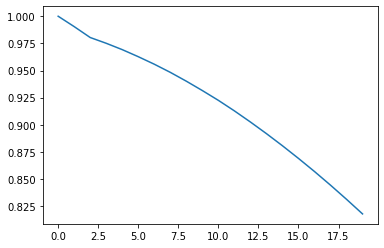

In [18]:
##Plot a list of Autocorrelation vs Values at lags
autocorr = []
for lag in range(0,20):
    print("Lag : " + str(lag) + "\n")
    rmse = sqrt(mean_squared_error(test[:len(predictions)],predictions))
    print(f"Test RMSE: {rmse}")
    df = pd.concat([values.shift(lag),values],axis =1)
    df.columns = ['t-'+str(lag),'t']
    result = df.corr()
    autocorr.append(result.t[0])
    print(result)
    print("\n\n")
    
plt.plot([i for i in (autocorr)])

# Get all anomalies

In [19]:
##Get all anomalies
serAnomaly = series[series.is_anomaly == 1]
insAnomaly = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M2_outliers.csv')

# allAnomaly = insAnomaly.set_index('timestamp').join(serAnomaly.set_index('timestamp'),on='timestamp',lsuffix="inserted",rsuffix="original")
allAnomaly = insAnomaly.join(serAnomaly.set_index('timestamp'),on='timestamp',lsuffix="inserted",rsuffix="original",how='outer')


In [20]:
allAnomaly

,timestamp,value,is_anomaly
0.0,1418965200,NaN,NaN
1.0,1418968800,NaN,NaN
2.0,1418972400,NaN,NaN
3.0,1418976000,NaN,NaN
4.0,1418979600,NaN,NaN
...,...,...,...
137.0,1419458400,NaN,NaN
138.0,1419462000,NaN,NaN
139.0,1419465600,NaN,NaN
NaN,1419940800,1270.928129,1.0


# Using AR to model whole TS

I'm planning on doing this by fitting the model on a TS, then running forecast/predict with the index arguments from 0 -> train + test

Of all the mutated datasets M1 - M5, The original series, M1 and M2 and M3 may be suitable for testing, I don't get M4 and M5 may overwhelm the results.

In [120]:
series = pd.read_csv('D://Temp/time-series/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv')
series.head()

,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0
3,1416736800,125.389424,0
4,1416740400,152.962000,0


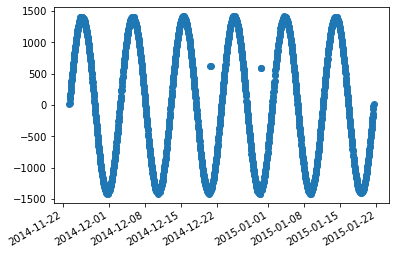

In [121]:
series['timestamp'] = pd.to_datetime(series['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
plt.plot_date(series['timestamp'],series['value'])
plt.gcf().autofmt_xdate()

In [122]:
# s1 = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M1.csv')
# s1.head()
# s1['timestamp'] = pd.to_datetime(s1['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
# plt.plot_date(s1['timestamp'],s1['value'])
# plt.gcf().autofmt_xdate()

# s2 = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M2.csv')
# s2.head()
# s2['timestamp'] = pd.to_datetime(s2['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
# plt.plot_date(s2['timestamp'],s2['value'])
# plt.gcf().autofmt_xdate()

# s3 = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M3.csv')
# s3.head()
# s3['timestamp'] = pd.to_datetime(s3['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
# plt.plot_date(s3['timestamp'],s3['value'])
# plt.gcf().autofmt_xdate()

# s4 = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M4.csv')
# s4.head()
# s4['timestamp'] = pd.to_datetime(s4['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
# plt.plot_date(s4['timestamp'],s4['value'])
# plt.gcf().autofmt_xdate()

# s5 = pd.read_csv('D://Temp/time-series/data/yahoo-mutated/A2/synthetic_1_value_M5.csv')
# s5.head()
# s5['timestamp'] = pd.to_datetime(s5['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
# plt.plot_date(s5['timestamp'],s5['value'])
# plt.gcf().autofmt_xdate()

In [123]:
# split dataset
X = series.value
size = int(len(X)*0.66) #
train, test = X[1:size], X[1:len(X)]

The above line is training the AR model on half the series and testing it on the whole series.

In [124]:
from statsmodels.tsa.ar_model import AutoReg
# train autoregression
model = AutoReg(train, lags=30)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept    0.044792
value.L1     1.011852
value.L2    -0.780653
value.L3     0.795057
value.L4    -0.596003
value.L5     0.618734
value.L6    -0.453771
value.L7     0.491607
value.L8    -0.356927
value.L9     0.387020
value.L10   -0.266390
value.L11    0.299744
value.L12   -0.213050
value.L13    0.240981
value.L14   -0.178501
value.L15    0.199117
value.L16   -0.148992
value.L17    0.161360
value.L18   -0.126329
value.L19    0.129396
value.L20   -0.107251
value.L21    0.084863
value.L22   -0.065008
value.L23    0.037844
value.L24   -0.058868
value.L25    0.031702
value.L26   -0.066747
value.L27    0.022899
value.L28   -0.070786
value.L29    0.016557
value.L30   -0.073607
dtype: float64


The below code makes the fitted AR model predict/model the TS from the first element to the last element, given it was trained on half the series. If it was trained on the whole series, then it seemed to overfit and predict everything perfectly.

In [125]:
# make predictions
predictions = model_fit.predict(start=1, end=len(X)-1, dynamic=False)
predictions = predictions.replace(np.nan,0)
for i in range(len(predictions)):
 	print('predicted=%f, expected=%f' % (predictions.iloc[i], test.iloc[i]))


predicted=0.000000, expected=33.578274
predicted=0.000000, expected=88.933746
predicted=0.000000, expected=125.389424
predicted=0.000000, expected=152.962000
predicted=0.000000, expected=168.365150
predicted=0.000000, expected=211.863425
predicted=0.000000, expected=255.452289
predicted=0.000000, expected=295.065010
predicted=0.000000, expected=357.805877
predicted=0.000000, expected=375.746934
predicted=0.000000, expected=394.292129
predicted=0.000000, expected=425.906754
predicted=0.000000, expected=470.487595
predicted=0.000000, expected=505.187174
predicted=0.000000, expected=538.400434
predicted=0.000000, expected=579.767391
predicted=0.000000, expected=600.841041
predicted=0.000000, expected=648.673567
predicted=0.000000, expected=663.043224
predicted=0.000000, expected=706.487417
predicted=0.000000, expected=744.904292
predicted=0.000000, expected=773.496164
predicted=0.000000, expected=811.607978
predicted=0.000000, expected=832.300396
predicted=0.000000, expected=868.047922
pr

In [126]:
len(test),len(predictions)

(1420, 1420)

In [127]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 292.560


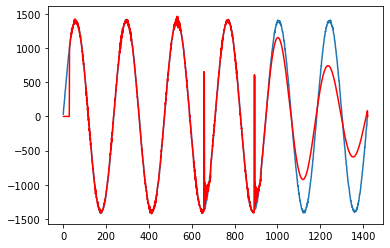

In [128]:
#plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

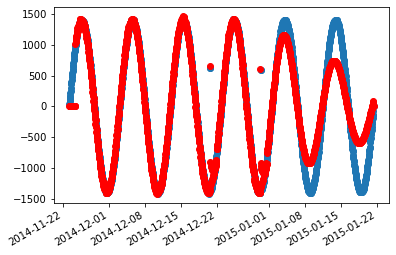

In [129]:
series['timestamp'] = pd.to_datetime(series['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
plt.plot_date(series['timestamp'][:len(series)-1],test)
plt.plot_date(series['timestamp'][:len(series)-1],predictions,color='red')
plt.gcf().autofmt_xdate()

In [139]:
df_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1421 entries, 2014-11-23 07:00:00 to 2015-01-21 11:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       1421 non-null   float64
 1   is_anomaly  1421 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 33.3 KB


In [140]:
predictdf.set_index('timestamp').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1422 entries, 2014-11-23 07:00:00 to NaT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1420 non-null   float64
dtypes: float64(1)
memory usage: 22.2 KB


In [130]:
predictdf = pd.concat([series['timestamp'][:len(series)-1],predictions], axis=1)

predictdf.rename(columns={0:'value'},inplace=True)

predictdf['value'] = predictdf['value'].shift(-2)

predictdf = predictdf.dropna()
predictdf

predictdf = predictdf.set_index('timestamp')

# Determine Seasonality

**WHY do this??**

If we know the seasonality, we can perform the right kind of differencing operation on the Time series to stationarize it. 
Maybe it will make the TS simpler to model and a simpler model will make the outliers stand out more in the model.

In [35]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# df_indexed = series.copy().set_index('timestamp')

# # Additive Decomposition
# result_add = seasonal_decompose(df_indexed['value'], model='additive', extrapolate_trend='freq')

# # Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# #result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

# Stationarize Time Series acc to Seasonality

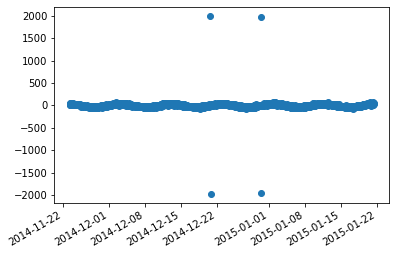

In [146]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset.iloc[i] - dataset.iloc[i - interval]
		diff.append(value)
	return pd.Series(diff)

interval = 1
stTS = difference(series['value'],interval)
plt.plot_date(series['timestamp'][interval:],stTS)
plt.gcf().autofmt_xdate()

Even thought the seasonality may be 7, 30, 365 days, differencing with lag = 1 is the most effective.

We can see that the outliers really stand out right now.

# Retrain AutoReg on Stationary TS

In [147]:
len(stTS),len(series)

(1420, 1421)

In [148]:
# split dataset
X = stTS
size = int(len(X)*0.66)
train, test = X[1:size], X[1:len(X)]

In [149]:
# train autoregression
model2 = AutoReg(train, lags=30)
model_fit2 = model2.fit()
print('Coefficients: %s' % model_fit2.params)

Coefficients: intercept   -0.433119
y.L1         0.072229
y.L2        -0.713174
y.L3         0.124020
y.L4        -0.480879
y.L5         0.164474
y.L6        -0.302092
y.L7         0.203720
y.L8        -0.169813
y.L9         0.221112
y.L10       -0.063377
y.L11        0.231869
y.L12       -0.000808
y.L13        0.230743
y.L14        0.032470
y.L15        0.219385
y.L16        0.051892
y.L17        0.199591
y.L18        0.057300
y.L19        0.173186
y.L20        0.054296
y.L21        0.127340
y.L22        0.058249
y.L23        0.086531
y.L24        0.032057
y.L25        0.059707
y.L26        0.007375
y.L27        0.032483
y.L28       -0.011530
y.L29        0.014560
y.L30       -0.018040
dtype: float64


The below code makes the fitted AR model predict/model the TS from the first element to the last element, given it was trained on half the series. If it was trained on the whole series, then it seemed to overfit and predict everything perfectly.

In [150]:
# make predictions
predictions2 = model_fit2.predict(start=1, end=len(X)-1, dynamic=False)
predictions2 = predictions2.replace(np.nan,0)
for i in range(len(predictions2)):
 	print('predicted=%f, expected=%f' % (predictions2.iloc[i], test.iloc[i]))


predicted=0.000000, expected=55.355473
predicted=0.000000, expected=36.455678
predicted=0.000000, expected=27.572576
predicted=0.000000, expected=15.403150
predicted=0.000000, expected=43.498275
predicted=0.000000, expected=43.588864
predicted=0.000000, expected=39.612721
predicted=0.000000, expected=62.740867
predicted=0.000000, expected=17.941057
predicted=0.000000, expected=18.545195
predicted=0.000000, expected=31.614625
predicted=0.000000, expected=44.580842
predicted=0.000000, expected=34.699579
predicted=0.000000, expected=33.213260
predicted=0.000000, expected=41.366957
predicted=0.000000, expected=21.073649
predicted=0.000000, expected=47.832526
predicted=0.000000, expected=14.369658
predicted=0.000000, expected=43.444193
predicted=0.000000, expected=38.416875
predicted=0.000000, expected=28.591872
predicted=0.000000, expected=38.111814
predicted=0.000000, expected=20.692418
predicted=0.000000, expected=35.747526
predicted=0.000000, expected=35.375579
predicted=0.000000, expec

In [151]:
len(predictions2),len(test),len(series)

(1419, 1419, 1421)

In [152]:
rmse = sqrt(mean_squared_error(test, predictions2))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 161.837


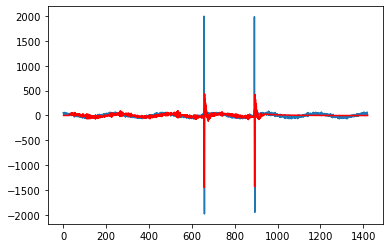

In [153]:
#plot results
plt.plot(test)
plt.plot(predictions2, color='red')
plt.show()

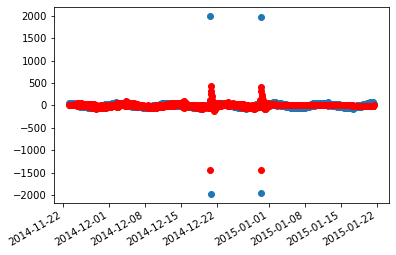

In [154]:
series['timestamp'] = pd.to_datetime(series['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
plt.plot_date(series['timestamp'][:len(series)-2],test)
plt.plot_date(series['timestamp'][:len(series)-2],predictions2,color='red')
plt.gcf().autofmt_xdate()

In [155]:
predictdf2 = pd.concat([series['timestamp'][:len(series)-1],predictions2], axis=1)

In [156]:
predictdf2.rename(columns={0:'value'},inplace=True)

In [157]:
predictdf2['value'] = predictdf2['value'].shift(-2)

In [158]:
predictdf2 = predictdf2.dropna()
predictdf2

,timestamp,value
0,2014-11-23 07:00:00,0.000000
1,2014-11-23 08:00:00,0.000000
2,2014-11-23 09:00:00,0.000000
3,2014-11-23 10:00:00,0.000000
4,2014-11-23 11:00:00,0.000000
...,...,...
1414,2015-01-21 05:00:00,-1.253968
1415,2015-01-21 06:00:00,-1.255753
1416,2015-01-21 07:00:00,-1.257518
1417,2015-01-21 08:00:00,-1.259265


# Test Stationarity using the Augmented Dicky Fuller Test

In [159]:
from statsmodels.tsa.stattools import adfuller
X = stTS
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.688285
p-value: 0.076088
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


The more negative this number, the more confidently we can reject the possiblity that the series is stationary. 

# Define threshold

Manually at the moment.

In [160]:
stTS

0       19.684242
1       55.355473
2       36.455678
3       27.572576
4       15.403150
          ...    
1415    46.052202
1416     1.761932
1417    69.107182
1418    53.693504
1419    24.614807
Length: 1420, dtype: float64

In [161]:
stTS.mean(), stTS.median(), stTS.mode()

(-0.00432138851108536,
 -0.3909807801651368,
 0    0.0
 dtype: float64)

Very obvious outliers, let's try setting the threshold manually for now to 500

In [162]:
threshold = 1200
st_threshold = 500

can also try the z score, or the inter quartile range method or the n std deviations method

# See if AR model + threshold = Anomalies

In [163]:
test

1       55.355473
2       36.455678
3       27.572576
4       15.403150
5       43.498275
          ...    
1415    46.052202
1416     1.761932
1417    69.107182
1418    53.693504
1419    24.614807
Length: 1419, dtype: float64

In [164]:
predictions, type(predictions)

(2        0.000000
 3        0.000000
 4        0.000000
 5        0.000000
 6        0.000000
           ...    
 1417    40.927783
 1418    54.961472
 1419    68.903486
 1420    82.744078
 1421     0.000000
 Length: 1420, dtype: float64,
 pandas.core.series.Series)

In [165]:
predictdf

,value
timestamp,
2014-11-23 07:00:00,0.000000
2014-11-23 08:00:00,0.000000
2014-11-23 09:00:00,0.000000
2014-11-23 10:00:00,0.000000
2014-11-23 11:00:00,0.000000
...,...
2015-01-21 06:00:00,40.927783
2015-01-21 07:00:00,54.961472
2015-01-21 08:00:00,68.903486


In [166]:
series

,timestamp,value,is_anomaly
0,2014-11-23 07:00:00,13.894031,0
1,2014-11-23 08:00:00,33.578274,0
2,2014-11-23 09:00:00,88.933746,0
3,2014-11-23 10:00:00,125.389424,0
4,2014-11-23 11:00:00,152.962000,0
...,...,...,...
1416,2015-01-21 07:00:00,-141.419766,0
1417,2015-01-21 08:00:00,-139.657834,0
1418,2015-01-21 09:00:00,-70.550652,0
1419,2015-01-21 10:00:00,-16.857148,0


In [167]:
series[series.is_anomaly == 1]

,timestamp,value,is_anomaly
658,2014-12-20 17:00:00,616.412915,1
659,2014-12-20 18:00:00,616.412915,1
893,2014-12-30 12:00:00,587.893627,1
894,2014-12-30 13:00:00,587.893627,1


In [168]:
threshold

1200

In [169]:
df_indexed

,value,is_anomaly
timestamp,,
2014-11-23 07:00:00,13.894031,0
2014-11-23 08:00:00,33.578274,0
2014-11-23 09:00:00,88.933746,0
2014-11-23 10:00:00,125.389424,0
2014-11-23 11:00:00,152.962000,0
...,...,...
2015-01-21 07:00:00,-141.419766,0
2015-01-21 08:00:00,-139.657834,0
2015-01-21 09:00:00,-70.550652,0


In [170]:
predictdf.set_index('timestamp')

KeyError: "None of ['timestamp'] are in the columns"

In [172]:
matrix = df_indexed.join(predictdf, on='timestamp',how='inner',lsuffix='_data',rsuffix='_predict')

In [173]:
matrix

,value_data,is_anomaly,value_predict
timestamp,,,
2014-11-23 07:00:00,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,0.000000
2014-11-23 10:00:00,125.389424,0,0.000000
2014-11-23 11:00:00,152.962000,0,0.000000
...,...,...,...
2015-01-21 06:00:00,-187.471968,0,40.927783
2015-01-21 07:00:00,-141.419766,0,54.961472
2015-01-21 08:00:00,-139.657834,0,68.903486


In [174]:
outliers = matrix[matrix.value_data > matrix.value_predict + threshold]

In [175]:
outliers

,value_data,is_anomaly,value_predict
timestamp,,,
2014-12-20 17:00:00,616.412915,1,-1308.358106
2014-12-20 18:00:00,616.412915,1,-964.645820
2014-12-30 12:00:00,587.893627,1,-1314.956439
2014-12-30 13:00:00,587.893627,1,-975.218905


In [61]:
# outliers = outliers.append(predictdf[predictdf['value'] < -1*(threshold)])

In [177]:
outliers

,value_data,is_anomaly,value_predict
timestamp,,,
2014-12-20 17:00:00,616.412915,1,-1308.358106
2014-12-20 18:00:00,616.412915,1,-964.645820
2014-12-30 12:00:00,587.893627,1,-1314.956439
2014-12-30 13:00:00,587.893627,1,-975.218905


In [178]:
outliers = matrix[matrix.value_data > matrix.value_predict + threshold]
not_outliers = matrix[matrix.value_data <= matrix.value_predict + threshold]
#not_outliers.append(predictdf[predictdf['value'] > -1*(threshold)])
not_outliers

,value_data,is_anomaly,value_predict
timestamp,,,
2014-11-23 07:00:00,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,0.000000
2014-11-23 10:00:00,125.389424,0,0.000000
2014-11-23 11:00:00,152.962000,0,0.000000
...,...,...,...
2015-01-21 06:00:00,-187.471968,0,40.927783
2015-01-21 07:00:00,-141.419766,0,54.961472
2015-01-21 08:00:00,-139.657834,0,68.903486


In [179]:
p = len(series[series.is_anomaly == 1])
p

n = len(series[series.is_anomaly == 0])
n

4

In [66]:
series.set_index('timestamp')

,value,is_anomaly
timestamp,,
2014-11-23 07:00:00,13.894031,0
2014-11-23 08:00:00,33.578274,0
2014-11-23 09:00:00,88.933746,0
2014-11-23 10:00:00,125.389424,0
2014-11-23 11:00:00,152.962000,0
...,...,...
2015-01-21 07:00:00,-141.419766,0
2015-01-21 08:00:00,-139.657834,0
2015-01-21 09:00:00,-70.550652,0


In [67]:
# predictdf.set_index('timestamp')

In [68]:
# series.set_index('timestamp').join(predictdf.set_index('timestamp'),on='timestamp',how='inner',lsuffix='_test',rsuffix='_predict')

In [69]:
outliers.set_index('timestamp')

,value
timestamp,
2014-11-24 19:00:00,1222.569742
2014-11-24 21:00:00,1277.195231
2014-11-24 22:00:00,1226.588701
2014-11-24 23:00:00,1291.052613
2014-11-25 00:00:00,1257.424279
...,...
2014-12-25 22:00:00,1272.816402
2014-12-25 23:00:00,1241.152499
2014-12-26 00:00:00,1245.177861


In [182]:
checkingmatrix = series.set_index('timestamp').join(outliers,on='timestamp',how='inner',lsuffix='_test',rsuffix='_predict')
checkingmatrix

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,
2014-12-20 17:00:00,616.412915,1,616.412915,1,-1308.358106
2014-12-20 18:00:00,616.412915,1,616.412915,1,-964.645820
2014-12-30 12:00:00,587.893627,1,587.893627,1,-1314.956439
2014-12-30 13:00:00,587.893627,1,587.893627,1,-975.218905


In [198]:
truepositives = checkingmatrix[checkingmatrix['is_anomaly_test'] == 1]
truepositives

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,
2014-12-20 17:00:00,616.412915,1,616.412915,1,-1308.358106
2014-12-20 18:00:00,616.412915,1,616.412915,1,-964.645820
2014-12-30 12:00:00,587.893627,1,587.893627,1,-1314.956439
2014-12-30 13:00:00,587.893627,1,587.893627,1,-975.218905


In [185]:
falsepostives = checkingmatrix[checkingmatrix['is_anomaly_test'] == 0]
falsepostives

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,


In [186]:
checkingmatrix2 =series.set_index('timestamp').join(not_outliers,on='timestamp',how='inner',lsuffix='_test',rsuffix='_predict')
checkingmatrix2

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,
2014-11-23 07:00:00,13.894031,0,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,88.933746,0,0.000000
2014-11-23 10:00:00,125.389424,0,125.389424,0,0.000000
2014-11-23 11:00:00,152.962000,0,152.962000,0,0.000000
...,...,...,...,...,...
2015-01-21 06:00:00,-187.471968,0,-187.471968,0,40.927783
2015-01-21 07:00:00,-141.419766,0,-141.419766,0,54.961472
2015-01-21 08:00:00,-139.657834,0,-139.657834,0,68.903486


In [188]:
truenegatives=checkingmatrix2[checkingmatrix2['is_anomaly_test'] == 0]
truenegatives

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,
2014-11-23 07:00:00,13.894031,0,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,88.933746,0,0.000000
2014-11-23 10:00:00,125.389424,0,125.389424,0,0.000000
2014-11-23 11:00:00,152.962000,0,152.962000,0,0.000000
...,...,...,...,...,...
2015-01-21 06:00:00,-187.471968,0,-187.471968,0,40.927783
2015-01-21 07:00:00,-141.419766,0,-141.419766,0,54.961472
2015-01-21 08:00:00,-139.657834,0,-139.657834,0,68.903486


In [189]:
truenegatives=checkingmatrix2[checkingmatrix2['is_anomaly_test'] == 0]
falsenegatives = checkingmatrix2[checkingmatrix2['is_anomaly_test'] == 1]
falsenegatives

,value,is_anomaly_test,value_data,is_anomaly_predict,value_predict
timestamp,,,,,


# Anomaly Detection with the differenced AR model

In [190]:
predictions2

2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
          ...   
1416   -1.253968
1417   -1.255753
1418   -1.257518
1419   -1.259265
1420    0.000000
Length: 1419, dtype: float64

In [191]:
predictions2.mean(),predictions2.std()

(0.4890141011905924, 64.42770009928446)

In [192]:
test

1       55.355473
2       36.455678
3       27.572576
4       15.403150
5       43.498275
          ...    
1415    46.052202
1416     1.761932
1417    69.107182
1418    53.693504
1419    24.614807
Length: 1419, dtype: float64

In [193]:
series

,timestamp,value,is_anomaly
0,2014-11-23 07:00:00,13.894031,0
1,2014-11-23 08:00:00,33.578274,0
2,2014-11-23 09:00:00,88.933746,0
3,2014-11-23 10:00:00,125.389424,0
4,2014-11-23 11:00:00,152.962000,0
...,...,...,...
1416,2015-01-21 07:00:00,-141.419766,0
1417,2015-01-21 08:00:00,-139.657834,0
1418,2015-01-21 09:00:00,-70.550652,0
1419,2015-01-21 10:00:00,-16.857148,0


In [194]:
predictdf2

,timestamp,value
0,2014-11-23 07:00:00,0.000000
1,2014-11-23 08:00:00,0.000000
2,2014-11-23 09:00:00,0.000000
3,2014-11-23 10:00:00,0.000000
4,2014-11-23 11:00:00,0.000000
...,...,...
1414,2015-01-21 05:00:00,-1.253968
1415,2015-01-21 06:00:00,-1.255753
1416,2015-01-21 07:00:00,-1.257518
1417,2015-01-21 08:00:00,-1.259265


In [81]:
len(predictdf2[predictdf2['value'] > st_threshold]),len(predictdf2[predictdf2['value'] < st_threshold])

(0, 1419)

In [82]:
len(predictdf2[predictdf2['value'] < (-1)*st_threshold]),len(predictdf2[predictdf2['value'] > (-1)*st_threshold])

(2, 1417)

In [83]:
st_threshold = 300

In [106]:
outliers2 = predictdf2[series['value'] > predictdf2['value'] + st_threshold]
#outliers2 = outliers2.append(predictdf2[predictdf2['value'] < (-1) * st_threshold])

ValueError: Can only compare identically-labeled Series objects

In [85]:
not_outliers2 =  predictdf2[predictdf2['value'] < st_threshold]
not_outliers2 =  not_outliers2.append(predictdf2[predictdf2['value'] > (-1) * st_threshold])

In [86]:
outliers2

,timestamp,value
658,2014-12-20 17:00:00,433.220002
660,2014-12-20 19:00:00,324.133493
893,2014-12-30 12:00:00,420.281450
895,2014-12-30 14:00:00,322.048679
656,2014-12-20 15:00:00,-1445.321706
891,2014-12-30 10:00:00,-1427.591171


In [87]:
outliers2.drop_duplicates(subset='timestamp')

,timestamp,value
658,2014-12-20 17:00:00,433.220002
660,2014-12-20 19:00:00,324.133493
893,2014-12-30 12:00:00,420.281450
895,2014-12-30 14:00:00,322.048679
656,2014-12-20 15:00:00,-1445.321706
891,2014-12-30 10:00:00,-1427.591171


In [88]:
not_outliers2

,timestamp,value
0,2014-11-23 07:00:00,0.000000
1,2014-11-23 08:00:00,0.000000
2,2014-11-23 09:00:00,0.000000
3,2014-11-23 10:00:00,0.000000
4,2014-11-23 11:00:00,0.000000
...,...,...
1414,2015-01-21 05:00:00,-1.253968
1415,2015-01-21 06:00:00,-1.255753
1416,2015-01-21 07:00:00,-1.257518
1417,2015-01-21 08:00:00,-1.259265


In [89]:
not_outliers2.drop_duplicates(subset='timestamp')

,timestamp,value
0,2014-11-23 07:00:00,0.000000
1,2014-11-23 08:00:00,0.000000
2,2014-11-23 09:00:00,0.000000
3,2014-11-23 10:00:00,0.000000
4,2014-11-23 11:00:00,0.000000
...,...,...
1418,2015-01-21 09:00:00,0.000000
658,2014-12-20 17:00:00,433.220002
660,2014-12-20 19:00:00,324.133493
893,2014-12-30 12:00:00,420.281450


In [90]:
outliers2 = outliers2.set_index('timestamp')
not_outliers2 = not_outliers2.set_index('timestamp')

In [91]:
posmatrix = df_indexed.join(outliers2, on='timestamp',how='inner',lsuffix = '_test',rsuffix='_predict')
negmatrix = df_indexed.join(not_outliers2, on='timestamp',how='inner',lsuffix = '_test',rsuffix='_predict')

In [92]:
posmatrix,negmatrix

(                      value_test  is_anomaly  value_predict
 timestamp                                                  
 2014-12-20 15:00:00 -1387.627020           0   -1445.321706
 2014-12-20 17:00:00   616.412915           1     433.220002
 2014-12-20 19:00:00 -1359.289813           0     324.133493
 2014-12-30 10:00:00 -1400.759329           0   -1427.591171
 2014-12-30 12:00:00   587.893627           1     420.281450
 2014-12-30 14:00:00 -1354.483291           0     322.048679,
                      value_test  is_anomaly  value_predict
 timestamp                                                 
 2014-11-23 07:00:00   13.894031           0       0.000000
 2014-11-23 07:00:00   13.894031           0       0.000000
 2014-11-23 08:00:00   33.578274           0       0.000000
 2014-11-23 08:00:00   33.578274           0       0.000000
 2014-11-23 09:00:00   88.933746           0       0.000000
 ...                         ...         ...            ...
 2015-01-21 07:00:00 -141.41976

In [93]:
negmatrix

,value_test,is_anomaly,value_predict
timestamp,,,
2014-11-23 07:00:00,13.894031,0,0.000000
2014-11-23 07:00:00,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,0.000000
2014-11-23 08:00:00,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,0.000000
...,...,...,...
2015-01-21 07:00:00,-141.419766,0,-1.257518
2015-01-21 08:00:00,-139.657834,0,-1.259265
2015-01-21 08:00:00,-139.657834,0,-1.259265


In [96]:
negmatrix.drop_duplicates()

,value_test,is_anomaly,value_predict
timestamp,,,
2014-11-23 07:00:00,13.894031,0,0.000000
2014-11-23 08:00:00,33.578274,0,0.000000
2014-11-23 09:00:00,88.933746,0,0.000000
2014-11-23 10:00:00,125.389424,0,0.000000
2014-11-23 11:00:00,152.962000,0,0.000000
...,...,...,...
2015-01-21 05:00:00,-201.528647,0,-1.253968
2015-01-21 06:00:00,-187.471968,0,-1.255753
2015-01-21 07:00:00,-141.419766,0,-1.257518


# Calculate F1 score

In [195]:
p = len(series[series.is_anomaly == 1])
p

4

In [196]:
n = len(series[series.is_anomaly == 0])
n

1417

In [199]:
precision = len(truepositives)/(len(truepositives) + len(falsepostives))

In [200]:
recall = len(truepositives)/(len(truepositives) + len(falsenegatives))

$$ F_1 = 2 * \frac{precision * recall}{precision +
recall} $$

In [201]:
f1 = 2*(precision * recall)/(precision + recall)

In [202]:
f1

1.0

# Doing this in a loop

In [207]:
import pandas as pd
from matplotlib import pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import glob
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg

In [208]:
start_time = datetime.now()
all_csv = glob.glob(f'../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/**/*.csv', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_csv)} files from disk. Took {end_time-start_time}')

Loaded the paths of 100 files from disk. Took 0:00:00.003989


Processing index: 0 of 100
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_1.csv
Test RMSE: 292.560


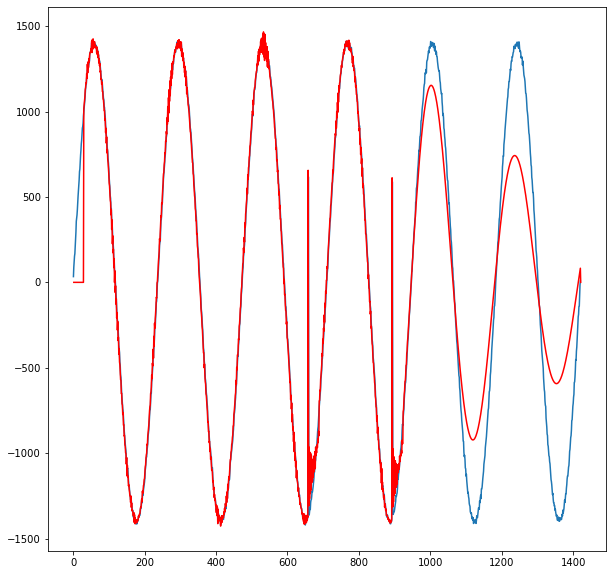

threshold:  1200
Outliers:
            value_data  is_anomaly  value_predict
timestamp                                        
1419094800  616.412915           1   -1308.358106
1419098400  616.412915           1    -964.645820
1419940800  587.893627           1   -1314.956439
1419944400  587.893627           1    -975.218905
Precision:  1.0
Recall: 1.0
F1: 1.0
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_10.csv
Test RMSE: 224.408


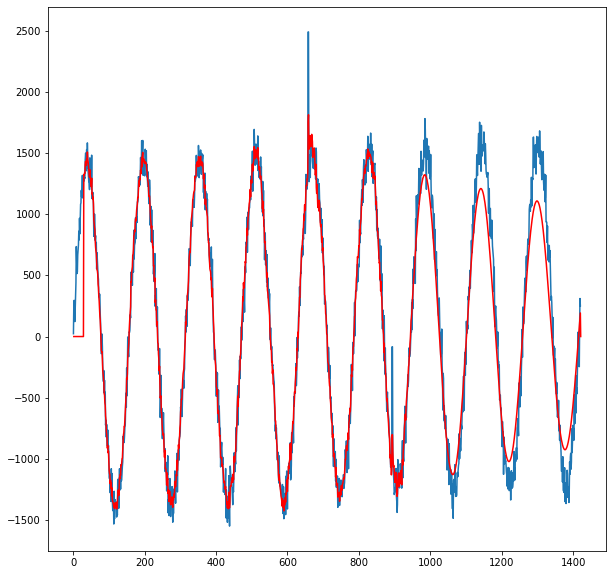

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416816000  1229.227433           0            0.0
1416819600  1317.557571           0            0.0
Precision:  0.0
Recall: 0.0
precision + recall = 0
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_100.csv
Test RMSE: 2865.760


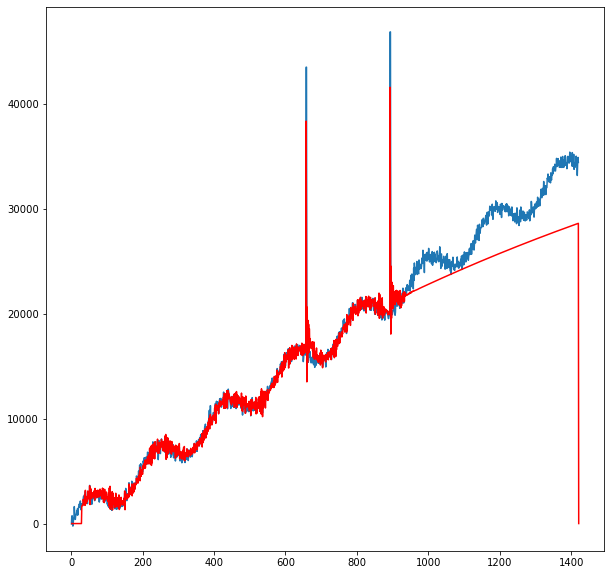

threshold:  1200
Outliers:
              value_data  is_anomaly  value_predict
timestamp                                          
1416758400   1617.147634           0       0.000000
1416783600   1219.643286           0       0.000000
1416790800   1419.903368           0       0.000000
1416798000   1278.488116           0       0.000000
1416801600   1579.963563           0       0.000000
...                  ...         ...            ...
1421820000  34188.268291           0   28592.749370
1421823600  34499.926302           0   28604.961922
1421827200  33192.985977           0   28617.167227
1421830800  34338.071070           0   28629.365289
1421834400  34919.246271           0       0.000000

[426 rows x 3 columns]
Precision:  0.009389671361502348
Recall: 1.0
F1: 0.0186046511627907
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_11.csv
Test RMSE: 1179.929


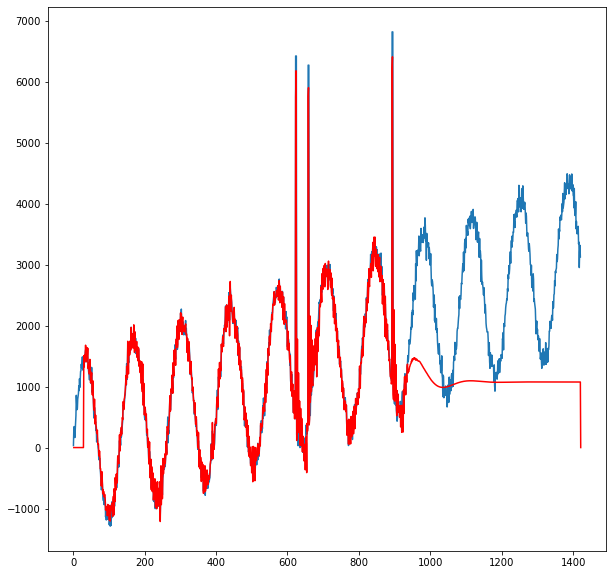

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416801600  1248.757108           0       0.000000
1416805200  1259.029372           0       0.000000
1416808800  1368.278985           0       0.000000
1416812400  1304.811674           0       0.000000
1416816000  1396.474559           0       0.000000
...                 ...         ...            ...
1421820000  3339.711467           0    1075.305792
1421823600  3370.568406           0    1075.306610
1421827200  2952.882613           0    1075.307286
1421830800  3213.559675           0    1075.307823
1421834400  3317.889934           0       0.000000

[304 rows x 3 columns]
Precision:  0.029605263157894735
Recall: 1.0
F1: 0.05750798722044728
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_12.csv
Test RMSE: 228.564


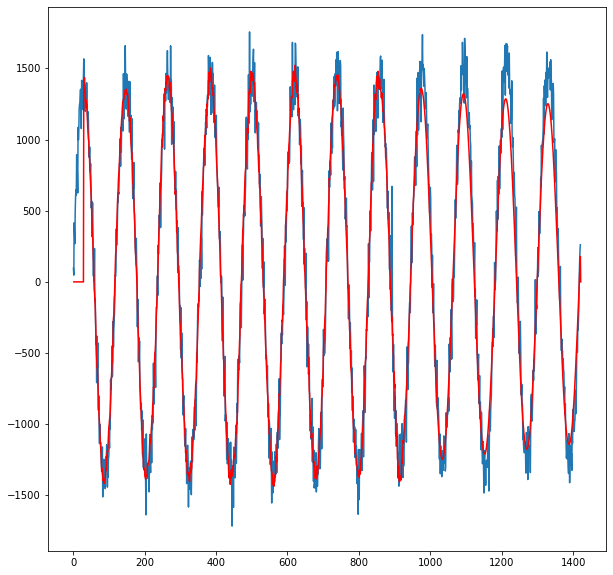

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416787200  1214.973114           0            0.0
1416790800  1244.719940           0            0.0
1416794400  1258.574484           0            0.0
1416798000  1335.929642           0            0.0
1416801600  1353.946650           0            0.0
1416805200  1299.361948           0            0.0
1416812400  1416.432797           0            0.0
1416816000  1354.561722           0            0.0
1416819600  1358.591609           0            0.0
1416823200  1211.696473           0            0.0
Precision:  0.0
Recall: 0.0
precision + recall = 0
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_13.csv
Test RMSE: 1051.955


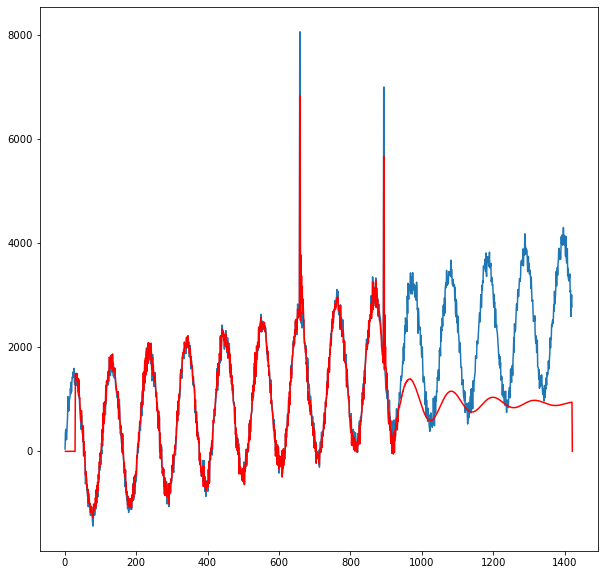

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416783600  1208.890315           0       0.000000
1416790800  1324.861891           0       0.000000
1416798000  1312.789459           0       0.000000
1416801600  1421.889456           0       0.000000
1416805200  1415.453603           0       0.000000
...                 ...         ...            ...
1421820000  3059.051221           0     941.118089
1421823600  3089.294936           0     942.322726
1421827200  2589.654340           0     943.452273
1421830800  2890.209375           0     944.504320
1421834400  3005.982663           0       0.000000

[283 rows x 3 columns]
Precision:  0.014134275618374558
Recall: 1.0
F1: 0.02787456445993031
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_14.csv
Test RMSE: 1775.812


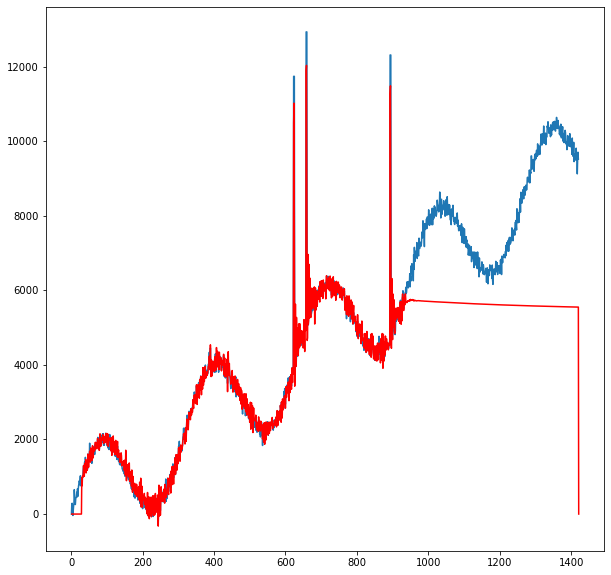

threshold:  1200
Outliers:
              value_data  is_anomaly  value_predict
timestamp                                          
1418968800  11741.659149           1    6542.874777
1418972400  11741.659149           1    3429.791454
1418976000  11741.659149           1    3832.119753
1419094800  12933.153180           1    7758.508167
1419098400  12933.153180           1    4656.286957
...                  ...         ...            ...
1421820000   9502.184262           0    5552.222476
1421823600   9598.339840           0    5552.012789
1421827200   9125.389925           0    5551.803620
1421830800   9514.644255           0    5551.594967
1421834400   9705.629910           0       0.000000

[394 rows x 3 columns]
Precision:  0.02284263959390863
Recall: 1.0
F1: 0.044665012406947896
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_15.csv
Test RMSE: 316.171


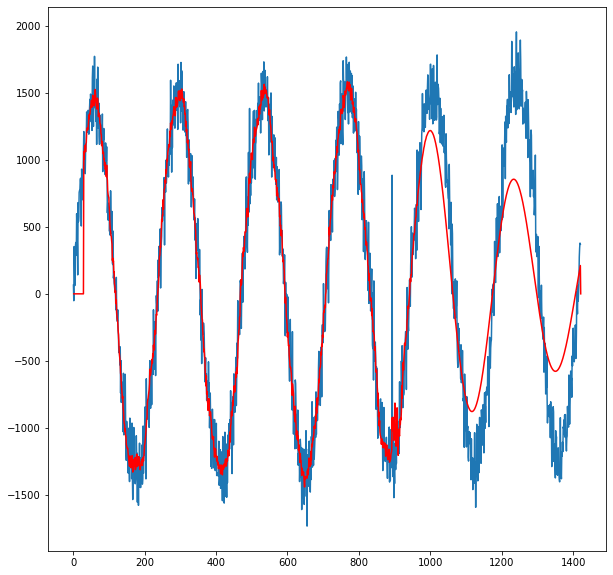

threshold:  1200
Outliers:
            value_data  is_anomaly  value_predict
timestamp                                        
1419940800  884.662693           1    -920.234724
Precision:  1.0
Recall: 1.0
F1: 1.0
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_16.csv
Test RMSE: 1908.025


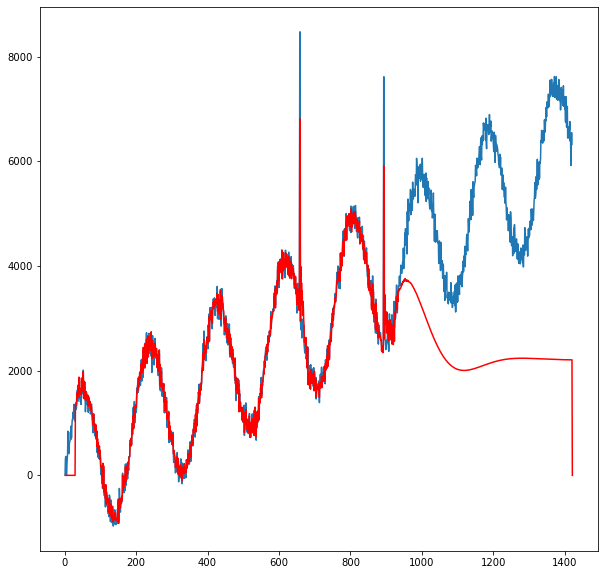

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416808800  1202.651486           0       0.000000
1416816000  1228.000506           0       0.000000
1416819600  1356.911467           0       0.000000
1419094800  8470.624612           1    2940.015400
1419098400  8470.624612           1    3987.440727
...                 ...         ...            ...
1421820000  6384.385709           0    2206.655968
1421823600  6476.736575           0    2206.592847
1421827200  5919.104142           0    2206.532882
1421830800  6345.859032           0    2206.476026
1421834400  6546.145013           0       0.000000

[459 rows x 3 columns]
Precision:  0.008714596949891068
Recall: 1.0
F1: 0.017278617710583158
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_17.csv
Test RMSE: 513.090


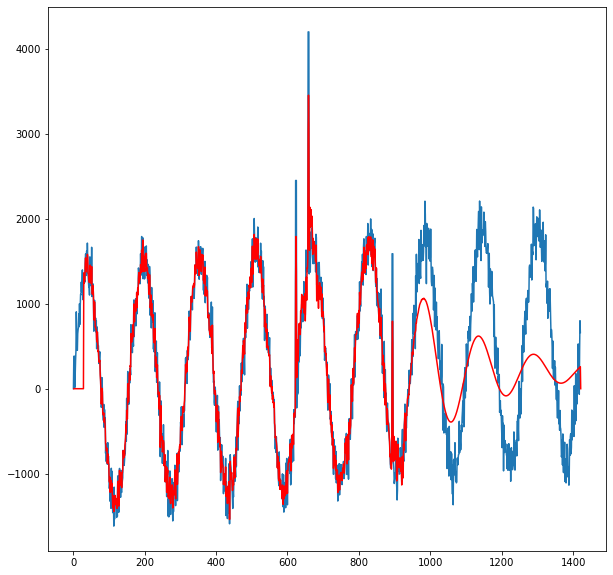

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416808800  1257.626649           0       0.000000
1416816000  1271.358475           0       0.000000
1416819600  1400.704468           0       0.000000
1418972400  2455.065872           1     130.945162
1418976000  2455.065872           1     195.362717
...                 ...         ...            ...
1421470800  1494.079436           0     275.278839
1421474400  1493.412017           0     268.394786
1421478000  1743.609018           0     261.468818
1421485200  1476.453797           0     247.539134
1421488800  1814.752196           0     240.559242

[66 rows x 3 columns]
Precision:  0.09090909090909091
Recall: 0.6666666666666666
F1: 0.16
Processing index: 10 of 100
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_18.csv
Test RMSE: 1628.560


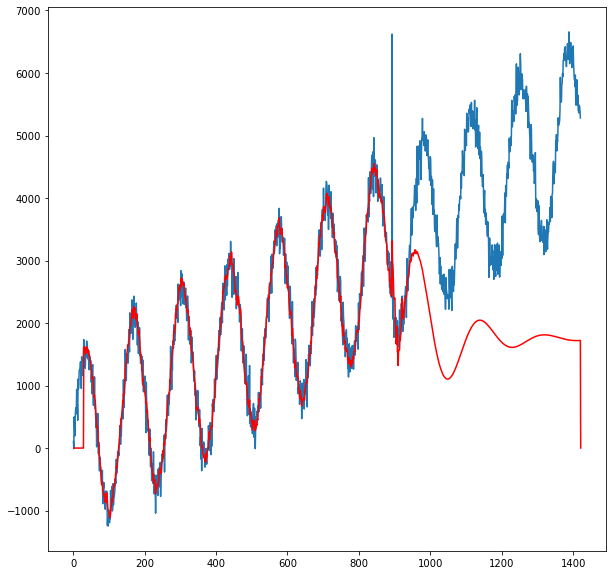

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416787200  1229.799064           0       0.000000
1416790800  1255.896957           0       0.000000
1416794400  1260.800900           0       0.000000
1416798000  1363.354505           0       0.000000
1416801600  1379.880517           0       0.000000
...                 ...         ...            ...
1421820000  5386.868942           0    1719.842577
1421823600  5360.860269           0    1720.111232
1421827200  5484.128799           0    1720.410939
1421830800  5460.006732           0    1720.740792
1421834400  5396.897182           0       0.000000

[442 rows x 3 columns]
Precision:  0.0022624434389140274
Recall: 1.0
F1: 0.004514672686230249
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_19.csv
Test RMSE: 439.092


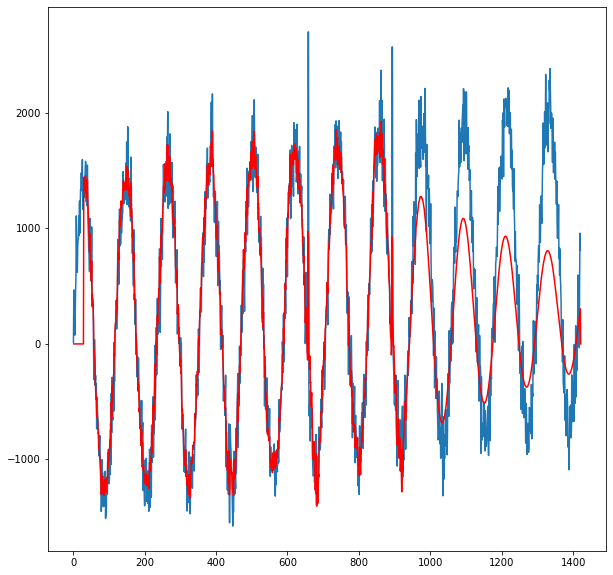

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416790800  1236.278596           0       0.000000
1416801600  1340.319149           0       0.000000
1416805200  1325.141090           0       0.000000
1416808800  1481.080770           0       0.000000
1416812400  1340.672423           0       0.000000
1416816000  1468.094194           0       0.000000
1416819600  1595.782423           0       0.000000
1416823200  1269.048776           0       0.000000
1419094800  2701.113338           1     -86.935354
1419098400  2701.113338           1    -118.095805
1419940800  2570.985949           1     222.540954
1419944400  2570.985949           1     101.431953
1420689600  2181.443430           0     955.233530
1421085600  2126.775049           0     926.198253
1421103600  2084.404475           0     877.974912
1421110800  2216.968361           0     846.229156
1421118000  2196.042105           0     807.930615
1421

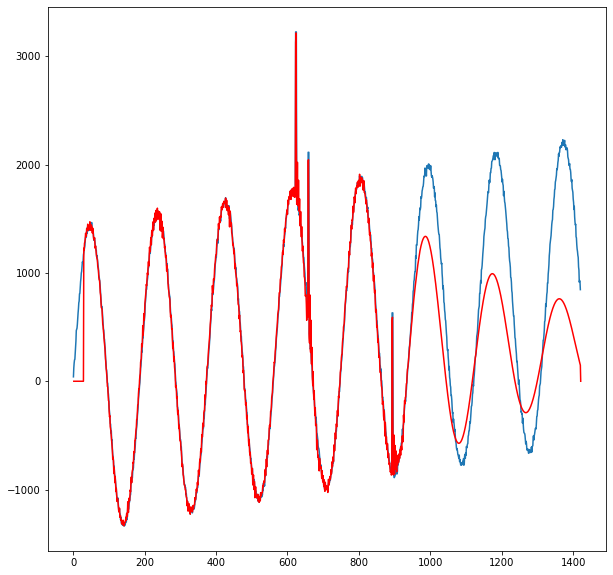

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1418972400  3225.596069           1    1633.844003
1418976000  3225.596069           1    1686.075452
1419098400  2114.071753           1     397.976148
1419102000  2114.071753           1     351.832956
1419944400   631.206140           1    -853.559441
...                 ...         ...            ...
1421762400  1745.615705           0     415.077685
1421766000  1683.449591           0     400.788252
1421769600  1652.661944           0     386.432235
1421773200  1586.120112           0     372.026075
1421776800  1616.016108           0     357.586195

[61 rows x 3 columns]
Precision:  0.09836065573770492
Recall: 0.6666666666666666
F1: 0.1714285714285714
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_20.csv
Test RMSE: 1337.196


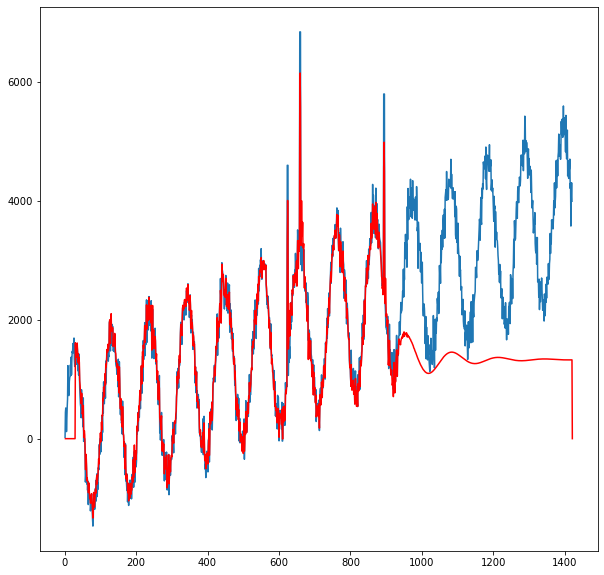

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1416758400  1227.625015           0       0.000000
1416783600  1240.673977           0       0.000000
1416790800  1371.149862           0       0.000000
1416798000  1314.542967           0       0.000000
1416801600  1466.590471           0       0.000000
...                 ...         ...            ...
1421820000  4208.157911           0    1324.375139
1421823600  4297.450702           0    1324.492395
1421827200  3574.346463           0    1324.619754
1421830800  4079.498966           0    1324.756721
1421834400  4301.449435           0       0.000000

[352 rows x 3 columns]
Precision:  0.02556818181818182
Recall: 1.0
F1: 0.04986149584487535
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_21.csv
Test RMSE: 1481.601


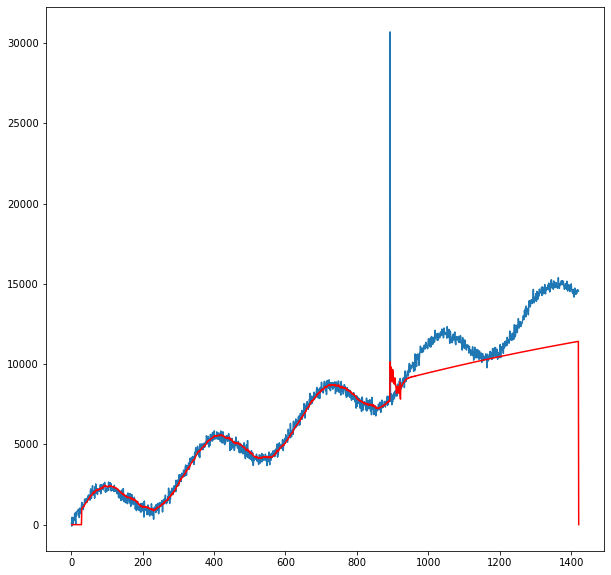

threshold:  1200
Outliers:
              value_data  is_anomaly  value_predict
timestamp                                          
1419940800  30692.054083           1    9471.770439
1420192800  10635.281016           0    9261.806327
1420203600  10585.005923           0    9281.459305
1420210800  10504.775873           0    9293.905257
1420218000  10515.519255           0    9304.392690
...                  ...         ...            ...
1421820000  14394.521490           0   11404.134884
1421823600  14416.503266           0   11408.103774
1421827200  14613.110972           0   11412.069660
1421830800  14638.354905           0   11416.032546
1421834400  14618.454059           0       0.000000

[311 rows x 3 columns]
Precision:  0.003215434083601286
Recall: 1.0
F1: 0.00641025641025641
file: ../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark\synthetic_22.csv
Test RMSE: 546.409


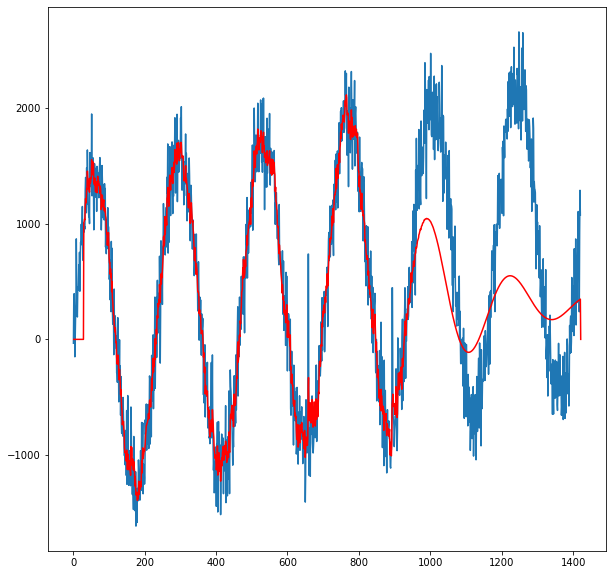

threshold:  1200
Outliers:
             value_data  is_anomaly  value_predict
timestamp                                         
1419094800   737.743951           1    -567.881616
1419098400   737.743951           1    -701.104294
1420272000  2393.654247           0    1041.833184
1420308000  2242.709387           0    1034.432704
1420315200  2274.044651           0    1023.869705
...                 ...         ...            ...
1421337600  1563.449517           0     334.584658
1421344800  1733.819768           0     324.550514
1421362800  1914.959749           0     300.154354
1421366400  1825.593025           0     295.419331
1421834400  1289.891987           0       0.000000

[93 rows x 3 columns]
Precision:  0.021505376344086023
Recall: 0.5
F1: 0.04123711340206186
AR Modelling and Anomaly Analysis of Yahoo S5 A2 Benchmark processing complete. Time taken:0:00:05.891064


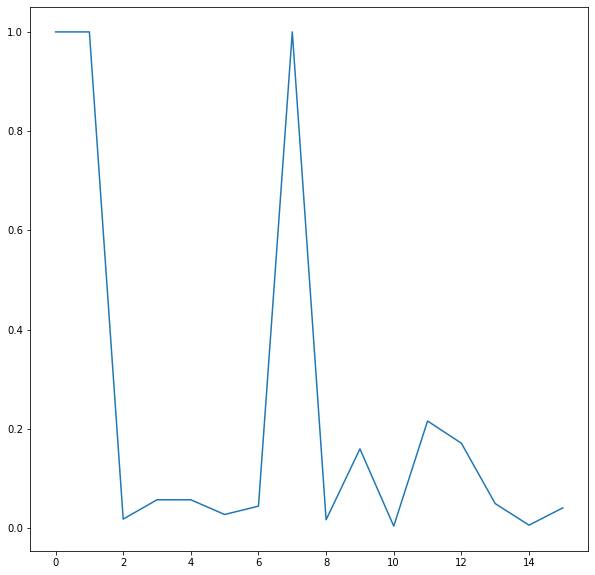

In [231]:
start_time = datetime.now() 
f1_plot = []
rmse_plot = []
precision_plot = []
recall_plot = []
for index,file in enumerate(all_csv):
    
    if index%10 == 0:
        print(f'Processing index: {index} of {len(all_csv)}')
    if index > 15:
         break
    
    fname = file.split("/")[5].replace('\\','').split(".")[0]
    df = pd.read_csv(file)
    df_indexed = df.set_index('timestamp')
    #print(df_indexed)
    
    # split dataset
    X = df.value
    size = int(len(X)*0.66)
    train, test = X[1:size], X[1:len(X)]
    
    # train autoregression
    model = AutoReg(train, lags=30)
    model_fit = model.fit()

    # make predictions
    predictions = model_fit.predict(start=1, end=len(X)-1, dynamic=False)
    predictions = predictions.replace(np.nan,0)

    #calculate rmse
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'file: {file}')
    print('Test RMSE: %.3f' % rmse)
    rmse_plot.append(rmse)
    
    #plot results
    #plt.rcParams.update({'figure.figsize': (10,10)})
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.savefig("./ARoutput/" + fname +"ARLag30")
    plt.show()
    
    
    predictdf = pd.concat([df['timestamp'][:len(df)-1],predictions], axis=1)
    predictdf.rename(columns={0:'value'},inplace=True)
    predictdf['value'] = predictdf['value'].shift(-2)
    predictdf = predictdf.dropna()
    predictdf = predictdf.set_index('timestamp')
    
    matrix = df_indexed.join(predictdf, on='timestamp',how='inner',lsuffix='_data',rsuffix='_predict')
    
    threshold = 1200
    
    outliers = matrix[matrix.value_data > matrix.value_predict + threshold]
    not_outliers = matrix[matrix.value_data <= matrix.value_predict + threshold]
    
    print("threshold: ", threshold)
    print("Outliers:")
    print(outliers)
    
    p = len(series[series.is_anomaly == 1])
    n = len(series[series.is_anomaly == 0])

    checkingmatrix = df.set_index('timestamp').join(outliers,on='timestamp',how='inner',lsuffix='_test',rsuffix='_predict')
    truepositives = checkingmatrix[checkingmatrix['is_anomaly_test'] == 1]
    falsepostives = checkingmatrix[checkingmatrix['is_anomaly_test'] == 0]
    
    checkingmatrix2 =df.set_index('timestamp').join(not_outliers,on='timestamp',how='inner',lsuffix='_test',rsuffix='_predict')
    truenegatives=checkingmatrix2[checkingmatrix2['is_anomaly_test'] == 0]
    falsenegatives = checkingmatrix2[checkingmatrix2['is_anomaly_test'] == 1]
    
    precision = len(truepositives)/(len(truepositives) + len(falsepostives))
    print("Precision: ", precision)
    precision_plot.append(precision)
    
    recall = len(truepositives)/(len(truepositives) + len(falsenegatives))
    print("Recall:", recall)
    recall_plot.append(recall)
    if(precision + recall > 0):
        f1 = 2*(precision * recall)/(precision + recall)
        print("F1:",f1)
    else:
        print("precision + recall = 0")
    f1_plot.append(f1)   

    
end_time=datetime.now()
print(f"AR Modelling and Anomaly Analysis of Yahoo S5 A2 Benchmark processing complete. Time taken:{end_time-start_time}")
plt.plot(f1_plot)

In [230]:
print(sum(f1_plot)/len(f1_plot))

0.2420691966355849
